First, convert bounding boxes to masks.
Then, apply unet.

In [0]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import os
import tensorflow as tf
#from tensorflow.python.keras.layers import concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Softmax,BatchNormalization,Activation,Input


In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive',force_remount=True)
#uploader = files.upload()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


create training data

In [0]:
#my_path = '/content/gdrive/My Drive/cleaned_data.zip (Unzipped Files)/drive-download-20181211t234626z-001.zip (Unzipped Files)'
train_bounding_box = np.load('/content/gdrive/My Drive/train_data.npy')
training_image = np.load('/content/gdrive/My Drive/copy_train_imgs.npy')
train_class = train_bounding_box[:,4]

#load augmented data
aug_images = np.load('/content/gdrive/My Drive/augmented_image.npy')
aug_class = np.zeros((aug_images.shape[0],))
aug_box = np.load('/content/gdrive/My Drive/augmented_boxes.npy')


#convert 
stacked_training_box = np.vstack((train_bounding_box[:,:4],aug_box))
train_x = np.reshape(np.sum((stacked_training_box[:,0] , .5 * stacked_training_box[:,3]),axis=0),(-1,1))
train_y = np.reshape(np.sum((stacked_training_box[:,1] , .5 * stacked_training_box[:,2]),axis=0),(-1,1))
train_bounding_box = np.hstack((train_x,train_y,stacked_training_box[:,2:]))
train_class = np.concatenate((train_class,aug_class),axis=0)
training_image = np.vstack((training_image,aug_images))


paths to the files

In [0]:
my_path = '/content/gdrive/My Drive/cleaned_data.zip (Unzipped Files)/drive-download-20181211t234626z-001.zip (Unzipped Files)'
train_bounding_box = np.load(my_path + '/train_data.npy')
training_image = np.load('/content/gdrive/My Drive/train_imgs.npy')
train_class = train_bounding_box[:,4]

#load augmented data
aug_images = np.load('/content/gdrive/My Drive/augmented_image.npy')
aug_class = np.zeros((aug_images.shape[0],))
aug_box = np.load('/content/gdrive/My Drive/augmented_boxes.npy')


#convert 
stacked_training_box = np.vstack((train_bounding_box[:,:4],aug_box))
train_x = np.reshape(np.sum((stacked_training_box[:,0] , .5 * stacked_training_box[:,3]),axis=0),(-1,1))
train_y = np.reshape(np.sum((stacked_training_box[:,1] , .5 * stacked_training_box[:,2]),axis=0),(-1,1))
train_bounding_box = np.hstack((train_x,train_y,stacked_training_box[:,2:]))
train_class = np.concatenate((train_class,aug_class),axis=0)
training_image = np.vstack((training_image,aug_images))


In [4]:
#define training model here
# -*- coding:utf-8 -*-
'''  
#====#====#====#====
# Originally implemented by DuFanXin and modified by Ken Hayashima 
# Original implementation is found at https://github.com/DuFanXin/U-net/blob/master/Unet/unet-Keras.py
#====#====#====#==== 
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Softmax,BatchNormalization,Activation
from keras.models import *
from keras.optimizers import *
from keras.utils import to_categorical
import keras.backend as K

class myUnet(object):
    def __init__(self, img_rows=256, img_cols=256):
        self.img_rows = img_rows
        self.img_cols = img_cols

    def get_body(self,pretrained_weights=None):
        inputs = Input(shape=(256, 256, 3),name = 'input')
        print(inputs.shape)
        conv1 = Conv2D(16, 3, padding='same', kernel_initializer='he_normal',name='conv1_1')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation='relu')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal',name='conv2_1')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation='relu')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal',name='conv3_1')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation='relu')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal',name='conv4_1')(pool3)
        conv4 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal',name='conv4_2')(conv4)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation='relu')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal',name='conv5_1')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation='relu')(conv5)
        drop5 = Dropout(0.5)(conv5)
        up6 = Conv2D(128, 2, padding='same', kernel_initializer='he_normal',name='up6')(UpSampling2D(size=(2, 2))(drop5))
        up6 = BatchNormalization()(up6)
        up6 = Activation(activation='relu')(up6)
        merge6 = concatenate([drop4, up6], axis=3)

        conv6 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal',name='conv6_1')(merge6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation(activation='relu')(conv6)
        up7 = Conv2D(64, 2, padding='same', kernel_initializer='he_normal',name='up7')( UpSampling2D(size=(2, 2))(conv6))
        up7 = BatchNormalization()(up7)
        up7 = Activation(activation='relu')(up7)
        merge7 = concatenate([conv3, up7], axis=3)
        conv7 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal',name='conv7_1')(merge7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation(activation='relu')(conv7)
        up8 = Conv2D(32, 2, padding='same', kernel_initializer='he_normal',name='up8')( UpSampling2D(size=(2, 2))(conv7))
        up8 = BatchNormalization()(up8)
        up8 = Activation(activation='relu')(up8)
        merge8 = concatenate([conv2, up8], axis=3) 
        conv8 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal',name='conv8_1')(merge8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation(activation='relu')(conv8)
        up9 = Conv2D(16, 2, padding='same', kernel_initializer='he_normal',name='up9')( UpSampling2D(size=(2, 2))(conv8))
        up9 = BatchNormalization()(up9)
        up9 = Activation(activation='relu')(up9)
        merge9 = concatenate([conv1, up9], axis=3)
        conv9 = Conv2D(16, 3, padding='same', kernel_initializer='he_normal',name='conv9_1')(merge9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation='relu')(conv9)
        conv9 = Conv2D(2, 3, padding='same', kernel_initializer='he_normal',name='conv9_3')(conv9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation='relu')(conv9)
        dense1 = Flatten()(conv9)
        out_class = Dense(1,activation='sigmoid',name='dense_class')(dense1)
        
        print(out_class.shape)
        
        model = Model(inputs=inputs,outputs=out_class)
        if pretrained_weights != None:
            model.load_weights(pretrained_weights,by_name = True)
        model.compile(optimizer=Adam(lr=1e-4), loss=['binary_crossentropy'], metrics=['accuracy'])
        print('model compile')
        return model
    def train(self,mode='already',img_paths = None,bounding_box_path = None,save_path=None,imgs_train_pre=None,imgs_mask_train_pre=None,pretrained_weights=None):
        if mode == 'already': 
            imgs_train,imgs_mask_train = imgs_train_pre,imgs_mask_train_pre
        else: 
            imgs_train, imgs_mask_train = load_training_data(save_path)
        print("loading data done")
        model = self.get_body(pretrained_weights)
        print("got unet") 
        if save_path is None:
          save_path = '.'
        model_checkpoint = ModelCheckpoint(save_path + '/unet_10layers_classifiers.hdf5', monitor='loss', verbose=1, save_best_only=True)
        print('Fitting model...')
        history = model.fit(x=imgs_train, y=imgs_mask_train, validation_split=0.2, batch_size=64, epochs=30, verbose=1, shuffle=True, callbacks=[model_checkpoint])
        return history

Using TensorFlow backend.


In [0]:
ten_layer_classifier = myUnet()
#history = ten_layer_classifier.train(imgs_train_pre=training_image/255,imgs_mask_train_pre=train_class)

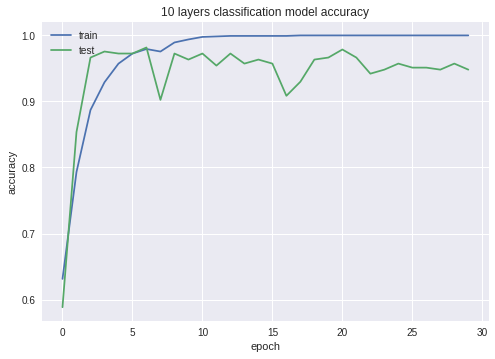

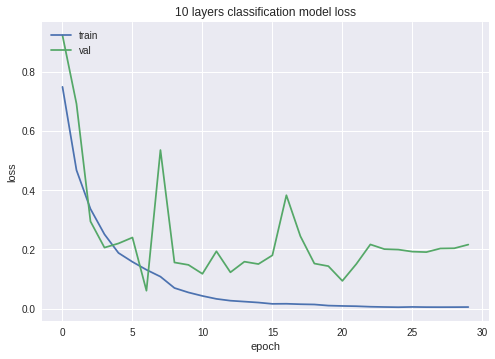

In [7]:

#plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('10 layers classification model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/gdrive/My Drive/10_layers_classifier_model_accuracy.png')

#plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('10 layers classification model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/content/gdrive/My Drive/10_layers_classifier_model_loss.png')

In [7]:
# validation on test
test_image = np.load('/content/gdrive/My Drive/test_imgs.npy')
model = ten_layer_classifier.get_body()
model.load_weights('/content/gdrive/My Drive/unet_10layers_classifiers.hdf5')
test_scores = model.predict(test_image/256, batch_size=16, verbose=1)
test_label = np.load('/content/gdrive/My Drive/test_data.npy')

(?, 256, 256, 16)
(?, 256, 256, 16)
(?, 128, 128, 16)


(?, 128, 128, 32)
(?, 64, 64, 32)


(?, 64, 64, 64)
(?, 32, 32, 64)


(?, 32, 32, 128)
(?, 16, 16, 128)


(?, 16, 16, 256)


(?, 32, 32, 128)
(?, 32, 32, 128)
merge: 
(?, 32, 32, 256)
(?, 1)
model compile
288/288 [==============================] - 6s 20ms/step


In [0]:
test_label = test_label[:,4]
test_fpr,test_tpr,_ = roc_curve(test_label,test_scores)
test_scores[test_scores<.5] = 0 
test_scores[test_scores >= .5] = 1 

In [14]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
print(f1_score(test_label,test_scores))
print(precision_score(test_label,test_scores))
print(recall_score(test_label,test_scores))


0.9493670886075949
0.9453781512605042
0.9533898305084746
